# Task 3
This serves as a template which will guide you through the implementation of this task. It is advised to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps.
This is the jupyter notebook version of the template. For the python file version, please refer to the file `template_solution.py`.

First, we import necessary libraries:

In [4]:
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
# Add any other imports you need here
# from torchinfo import summary
import time

In [5]:
# The device is automatically set to GPU if available, otherwise CPU
# If you want to force the device to CPU, you can change the line to
# device = torch.device("cpu")
# When using the GPU, it is important that your model and all data are on the 
# same device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from torchvision.models import resnet50, ResNet50_Weights
dnet = resnet50(weights=ResNet50_Weights.DEFAULT)
dnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
torch.nn.Sequential(*(list(dnet.children())[:-1]))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [7]:
print(dnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
m = dnet.features

In [5]:
dnet.classifier

Linear(in_features=1664, out_features=1000, bias=True)

In [6]:
# summary(m, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1664, 7, 7]           --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─_DenseBlock: 1-5                       [1, 256, 56, 56]          --
│    └─_DenseLayer: 2-1                  [1, 32, 56, 56]           --
│    │    └─BatchNorm2d: 3-1             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-2                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-3                  [1, 128, 56, 56]          8,192
│    │    └─BatchNorm2d: 3-4             [1, 128, 56, 56]          256
│    │    └─ReLU: 3-5                    [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-6                  [1, 32, 56, 56]           36,864
│ 

In [4]:
"""
Transform, resize and normalize the images and then use a pretrained model to extract 
the embeddings.
"""
# TODO: define a transform to pre-process the images
# The required pre-processing depends on the pre-trained model you choose 
# below. 
# See https://pytorch.org/vision/stable/models.html#using-the-pre-trained-models
# train_transforms = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor()])

train_transforms = ResNet50_Weights.DEFAULT.transforms()

train_dataset = datasets.ImageFolder(root="dataset/", transform=train_transforms)
# Hint: adjust batch_size and num_workers to your PC configuration, so that you don't 
# run out of memory (VRAM if on GPU, RAM if on CPU)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=64,
                          shuffle=False,
                          pin_memory=True, num_workers=4)

# TODO: define a model for extraction of the embeddings (Hint: load a pretrained model,
# more info here: https://pytorch.org/vision/stable/models.html)
model = torch.nn.Sequential(*(list(dnet.children())[:-1]))
model.to(device)
model.eval()
embedding_size = 0# Dummy variable, replace with the actual embedding size once you 
# pick your model

In [10]:
import time
num_images = len(train_dataset)
embeddings = np.zeros((num_images, 2048))
# TODO: Use the model to extract the embeddings. Hint: remove the last layers of the 
# model to access the embeddings the model generates. 

start = time.time()
i = 0
for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        embeddings[i*64:(i+1)*64] = model(images).cpu().numpy().squeeze()
    batch_time = time.time()
    print(i, batch_time-start)
    start = batch_time
    i += 1
np.save('dataset/embeddings.npy', embeddings)

0 14.444622993469238
1 3.8917529582977295
2 4.021626949310303
3 3.9441399574279785
4 3.9351119995117188
5 4.06097412109375
6 4.079049825668335
7 4.136859893798828
8 4.0602192878723145
9 4.074254989624023
10 4.0907299518585205
11 4.199393033981323
12 4.09377908706665
13 4.139988899230957
14 4.138470888137817
15 4.1898980140686035
16 4.1095311641693115
17 4.084611892700195
18 4.064064979553223
19 4.048243999481201
20 4.14080810546875
21 4.020444869995117
22 4.0457470417022705
23 4.058849096298218
24 4.1012678146362305
25 4.575926065444946
26 4.973726987838745
27 4.805560111999512
28 4.159907817840576
29 3.968776226043701
30 3.903810739517212
31 3.9304959774017334
32 3.9905242919921875
33 4.015681982040405
34 4.065490007400513
35 4.070931911468506
36 4.188259124755859
37 4.151155948638916
38 4.005660772323608
39 3.9350621700286865
40 3.919800043106079
41 3.9161949157714844
42 4.080542087554932
43 4.06306791305542
44 4.103945016860962
45 4.106230974197388
46 3.9890780448913574
47 4.0286459

In [6]:
def get_data(file, train=True):
    """
    Load the triplets from the file and generate the features and labels.

    input: file: string, the path to the file containing the triplets
          train: boolean, whether the data is for training or testing

    output: X: numpy array, the features
            y: numpy array, the labels
    """
    triplets = []
    with open(file) as f:
        for line in f:
            triplets.append(line)

    # generate training data from triplets
    train_dataset = datasets.ImageFolder(root="dataset/",
                                         transform=None)
    filenames = [s[0].split('/')[-1].replace('.jpg', '') for s in train_dataset.samples]
    # print(filenames)
    embeddings = np.load('dataset/embeddings.npy')
    # TODO: Normalize the embeddings
    # statistical normalization
    # embeddings = (embeddings - np.mean(embeddings, axis=0)) / np.std(embeddings, axis=0)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    file_to_embedding = {}
    for i in range(len(filenames)):
        file_to_embedding[filenames[i]] = embeddings[i]
    X = []
    y = []
    # use the individual embeddings to generate the features and labels for triplets
    for t in triplets:
        emb = [file_to_embedding[a] for a in t.split()]
        X.append(np.hstack([emb[0], emb[1], emb[2]]))
        y.append(1)
        # Generating negative samples (data augmentation)
        if train:
            X.append(np.hstack([emb[0], emb[2], emb[1]]))
            y.append(0)
    X = np.vstack(X)
    y = np.hstack(y)
    print(X.shape, y.shape)
    return X, y

Hint: adjust batch_size and num_workers to your PC configuration, so that you don't run out of memory (VRAM if on GPU, RAM if on CPU)

In [7]:
def create_loader_from_np(X, y = None, train = True, batch_size=64, shuffle=True, num_workers = 4):
    """
    Create a torch.utils.data.DataLoader object from numpy arrays containing the data.

    input: X: numpy array, the features
           y: numpy array, the labels
    
    output: loader: torch.data.util.DataLoader, the object containing the data
    """
    if train:
        # Attention: If you get type errors you can modify the type of the
        # labels here
        dataset = TensorDataset(torch.from_numpy(X).type(torch.float), 
                                torch.from_numpy(y).type(torch.float))
    else:
        dataset = TensorDataset(torch.from_numpy(X).type(torch.float))
    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle,
                        pin_memory=True, num_workers=num_workers)
    print(loader.dataset.tensors[0].shape, loader.dataset.tensors[1].shape if train else None)
    return loader

TODO: define a model. Here, the basic structure is defined, but you need to fill in the details

In [29]:
class Net(nn.Module):
    """
    The model class, which defines our classifier.
    """
    def __init__(self):
        """
        The constructor of the model.
        """
        super().__init__()
        self.dropout0 = nn.Dropout(0.5)
        self.fc0 = nn.Linear(6144, 1024)
        self.bn0 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1024, 256)
        self.bn1 = nn.BatchNorm1d(256)
        # self.fc4 = nn.Linear(128, 1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        # self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        """
        The forward pass of the model.

        input: x: torch.Tensor, the input to the model

        output: x: torch.Tensor, the output of the model
        """
        x = self.dropout0(x)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.sigmoid(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.sigmoid(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        return x

Net()
# summary(Net())

Net(
  (dropout0): Dropout(p=0.5, inplace=False)
  (fc0): Linear(in_features=6144, out_features=1024, bias=True)
  (bn0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
def one_unseen(triple, indices):
    return any([t in indices for t in triple])

def two_unseen(triple, indices):
    """
    Check if exactly two of the images in the triple are unseen.
    """
    return sum([t in indices for t in triple]) == 2

def split_file_by_image(filename):
    """
    Split the dataset by image. Randomly generates a list of image indices and then
    checks if each triple in the file contains the indices. If so, hold out the triple for the
    validation set. Otherwise, add the triple to the training set. At the end, write the
    training and validation sets to separate files.
    """
    TRAIN = 'train.txt'
    VAL_ONE_UNSEEN = 'val_one_unseen.txt'
    VAL_TWO_UNSEEN = 'val_two_unseen.txt'

    # generate a list of image indices
    image_indices = np.random.choice(5000, 1000, replace=False)
    assert len(image_indices) == 1000

    # clear the files
    open(TRAIN, 'w').close()
    open(VAL_ONE_UNSEEN, 'w').close()
    open(VAL_TWO_UNSEEN, 'w').close()

    train_file = open(TRAIN, 'a')
    one_unseen_file = open(VAL_ONE_UNSEEN, 'a')
    two_unseen_file = open(VAL_TWO_UNSEEN, 'a')

    with open(filename) as f:
        lines = f.readlines()
        for l in lines:
            triples = [int(t) for t in l.split()]
            if two_unseen(triples, image_indices):
                one_unseen_file.write(l)
                two_unseen_file.write(l)
            elif one_unseen(triples, image_indices):
                one_unseen_file.write(l)
            else:
                train_file.write(l)
    train_file.close()
    one_unseen_file.close()
    two_unseen_file.close()

split_file_by_image('train_triplets.txt')

In [30]:
TRAIN = 'train.txt'

# load the training data
X, y = get_data(TRAIN)
# Create data loaders for the training data
train_loader = create_loader_from_np(X, y, train = True, batch_size=128)
# delete the loaded training data to save memory, as the data loader copies
del X
del y

(60816, 6144) (60816,)
torch.Size([60816, 6144]) torch.Size([60816])


In [11]:
VAL_ONE_UNSEEN = 'val_one_unseen.txt'
VAL_TWO_UNSEEN = 'val_two_unseen.txt'

# load the validation data
X_val, y_val = get_data(VAL_ONE_UNSEEN, train=True)
# Create data loaders for the validation data
val_loader_one_unseen = create_loader_from_np(X_val, y_val, train = True, batch_size=128)
# delete the loaded validation data to save memory, as the data loader copies
del X_val
del y_val

# load the validation data
X_val, y_val = get_data(VAL_TWO_UNSEEN, train=True)
# Create data loaders for the validation data
val_loader_two_unseen = create_loader_from_np(X_val, y_val, train = True, batch_size=128)
# delete the loaded validation data to save memory, as the data loader copies
del X_val
del y_val

(58214, 6144) (58214,)
torch.Size([58214, 6144]) torch.Size([58214])
(11336, 6144) (11336,)
torch.Size([11336, 6144]) torch.Size([11336])


In [23]:
train_loader.dataset.tensors[0].shape

torch.Size([119030, 6144])

In [34]:
"""
The training procedure of the model; it accepts the training data, defines the model 
and then trains it.

input: train_loader: torch.data.util.DataLoader, the object containing the training data
    
compute: model: torch.nn.Module, the trained model
"""
model = Net()
# model.train()
model.to(device)
n_epochs = 20

train_loss = []
train_accuracy = []
val_accuracy_one_unseen = []
val_accuracy_two_unseen = []

TRAIN_TRIPLETS = 'train_triplets.txt'

# load the training data
X, y = get_data(TRAIN_TRIPLETS)
# Create data loaders for the training data
train_loader = create_loader_from_np(X, y, train = True, batch_size=128)
# delete the loaded training data to save memory, as the data loader copies
del X
del y

# TODO: define a loss function, optimizer and proceed with training. Hint: use the part 
# of the training data as a validation split. After each epoch, compute the loss on the 
# validation split and print it out. This enables you to see how your model is performing 
# on the validation data before submitting the results on the server. After choosing the 
# best model, train it on the whole training data.

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.BCEWithLogitsLoss()
start = time.time()

for epoch in range(n_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).float()
        optimizer.zero_grad()
        output = model(data).squeeze(1)
        prob = torch.sigmoid(output)
        predicted = (prob > 0.5).float()
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

        # print(output, output.shape, output.dtype)
        # print(target, target.shape, target.dtype)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        if i == 0:
            epoch_time = time.time()
            print(f'Epoch {epoch}, batch {i}, loss {l.item()}, time {epoch_time-start}')
            start = epoch_time
    train_loss.append(l.item())
    train_accuracy.append(100 * correct_train / total_train)
    model.eval()

    with torch.no_grad():

        correct_one_unseen = 0
        total_one_unseen = 0
        for j, (data, target) in enumerate(val_loader_one_unseen):
            data, target = data.to(device), target.to(device).float()
            outputs = model(data).squeeze(1)
            probs = torch.sigmoid(outputs)
            # Classify the probabilities into class predictions
            predicted = (probs > 0.5).float()
            total_one_unseen += target.size(0)
            correct_one_unseen += (predicted == target).sum().item()
        acc_one_unseen = 100 * correct_one_unseen / total_one_unseen
        
        correct_two_unseen = 0
        total_two_unseen = 0
        for j, (data, target) in enumerate(val_loader_two_unseen):
            data, target = data.to(device), target.to(device).float()
            outputs = model(data).squeeze(1)
            probs = torch.sigmoid(outputs)
            # Classify the probabilities into class predictions
            predicted = (probs > 0.5).float()
            total_two_unseen += target.size(0)
            correct_two_unseen += (predicted == target).sum().item()
        acc_two_unseen = 100 * correct_two_unseen / total_two_unseen
    val_accuracy_one_unseen.append(acc_one_unseen)
    val_accuracy_two_unseen.append(acc_two_unseen)

    print(f'Epoch {epoch}, \n validation accuracy for triplets with one unseen image: {acc_one_unseen}, \n validation accuracy for triplets with two unseen images: {acc_two_unseen}')

# # Save the model
# torch.save(model.state_dict(), 'model.pth')
    

(119030, 6144) (119030,)
torch.Size([119030, 6144]) torch.Size([119030])
Epoch 0, batch 0, loss 0.7305436730384827, time 4.183431148529053
Epoch 0, 
 validation accuracy for triplets with one unseen image: 58.68863160064589, 
 validation accuracy for triplets with two unseen images: 59.14784756527876
Epoch 1, batch 0, loss 0.6746851801872253, time 73.20633888244629
Epoch 1, 
 validation accuracy for triplets with one unseen image: 60.41502044181812, 
 validation accuracy for triplets with two unseen images: 60.72688779110798
Epoch 2, batch 0, loss 0.6973123550415039, time 73.76604318618774
Epoch 2, 
 validation accuracy for triplets with one unseen image: 71.19936784965816, 
 validation accuracy for triplets with two unseen images: 71.36556104446012
Epoch 3, batch 0, loss 0.6541366577148438, time 77.29518580436707
Epoch 3, 
 validation accuracy for triplets with one unseen image: 74.1591369773594, 
 validation accuracy for triplets with two unseen images: 74.07374735356387
Epoch 4, bat

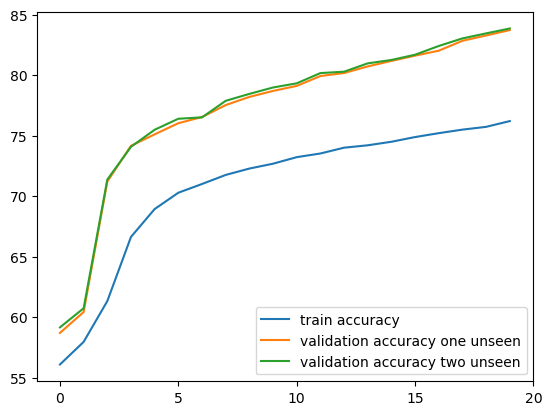

In [35]:
# plot the training and validation accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_accuracy, label='train accuracy')
plt.plot(val_accuracy_one_unseen, label='validation accuracy one unseen')
plt.plot(val_accuracy_two_unseen, label='validation accuracy two unseen')
plt.xticks(range(0, len(train_accuracy)+1, 5))
plt.legend()
# save the plot
# plt.savefig('accuracy_large_model_40_epochs.png')
plt.show()

In [27]:
TEST_TRIPLETS = 'test_triplets.txt'

# repeat for testing data
X_test, y_test = get_data(TEST_TRIPLETS, train=False)
test_loader = create_loader_from_np(X_test, train = False, batch_size=2048, shuffle=False)
del X_test
del y_test

(59544, 6144) (59544,)
torch.Size([59544, 6144]) None


In [36]:
"""
The testing procedure of the model; it accepts the testing data and the trained model and 
then tests the model on it.

input: model: torch.nn.Module, the trained model
       loader: torch.data.util.DataLoader, the object containing the testing data
        
compute: None, the function saves the predictions to a results.txt file
"""
model.eval()
predictions = []
# Iterate over the test data
with torch.no_grad(): # We don't need to compute gradients for testing
    for [x_batch] in test_loader:
        x_batch= x_batch.to(device)
        predicted = torch.sigmoid(model(x_batch))
        predicted = predicted.cpu().numpy()
        # Rounding the predictions to 0 or 1
        predicted[predicted >= 0.5] = 1
        predicted[predicted < 0.5] = 0
        predictions.append(predicted)
    predictions = np.vstack(predictions)
np.savetxt("results.txt", predictions, fmt='%i')
print("Results saved to results.txt")

Results saved to results.txt
